In [1]:
import os
import numpy as np
from cufolio import cvar_optimizer, cvar_utils, utils, rebalance
from cufolio.cvar_parameters import CvarParameters
import cvxpy as cp

In [4]:
# --- Global Data Settings ---
# Define dataset paths and common parameters
sp500_dataset_name = "sp500"
sp500_dataset_directory = f"../data/stock_data/{sp500_dataset_name}.csv"

global_titans_dataset_name = "global_titans"
global_titans_dataset_directory = f"../data/stock_data/{global_titans_dataset_name}.csv"

log_return_type = "LOG" # Common return type

In [3]:
# CVaR Parameters for Rebalancing (Sections 4, 5 and part of 6)
# Used for basic rebalancing strategies and the "no turnover constraint" comparison in section 6
rebal_cvar_params = CvarParameters(
    w_min=-0.3,
    w_max=0.8,
    c_min=0.1,
    c_max=0.4,
    L_tar=1.6,
    T_tar=1,       # No explicit turnover constraint initially for some rebalancing strategies
    cvar_limit=None,  # Stricter CVaR risk limit for rebalancing
    risk_aversion=0.2,
    confidence=0.95,
    num_scen=20000,
    fit_type="kde"
)

# CVaR Parameters for Rebalancing with Transaction Costs & Turnover (Section 6)
rebal_tc_cvar_params = CvarParameters(
    w_min=-0.3,
    w_max=0.8,
    c_min=0.1,
    c_max=0.4,
    L_tar=1.6,
    T_tar=0.5,        # Turnover constraint for transaction cost rebalancing
    cvar_limit=0.02,
    risk_aversion=1,
    confidence=0.95,
    num_scen=10000,
    fit_type="kde"
)

BASELINE (BUY & HOLD) ANALYSIS
Period: 2022-07-01 to 2024-05-01
Strategy: Single optimization at start
Setting parameter log_to_console to false

BASELINE COMPLETE
Final portfolio value: $1.02
Total return: +6.80%
Data points collected: 441

DYNAMIC REBALANCING ANALYSIS
Period: 2022-07-01 to 2024-05-01
Strategy: Percentage Change
Threshold: -0.005
Look-forward window: 21 days
Look-back window: 252 days
Setting parameter log_to_console to false
Rebalancing triggered on 2022-09-30 | Event #1 | Portfolio value: $1.16
Setting parameter log_to_console to false
Rebalancing triggered on 2022-11-30 | Event #2 | Portfolio value: $1.12
Setting parameter log_to_console to false
Rebalancing triggered on 2023-02-01 | Event #3 | Portfolio value: $1.03
Setting parameter log_to_console to false
Rebalancing triggered on 2023-06-02 | Event #4 | Portfolio value: $1.10
Setting parameter log_to_console to false
Rebalancing triggered on 2023-08-03 | Event #5 | Portfolio value: $1.07
Setting parameter log_to

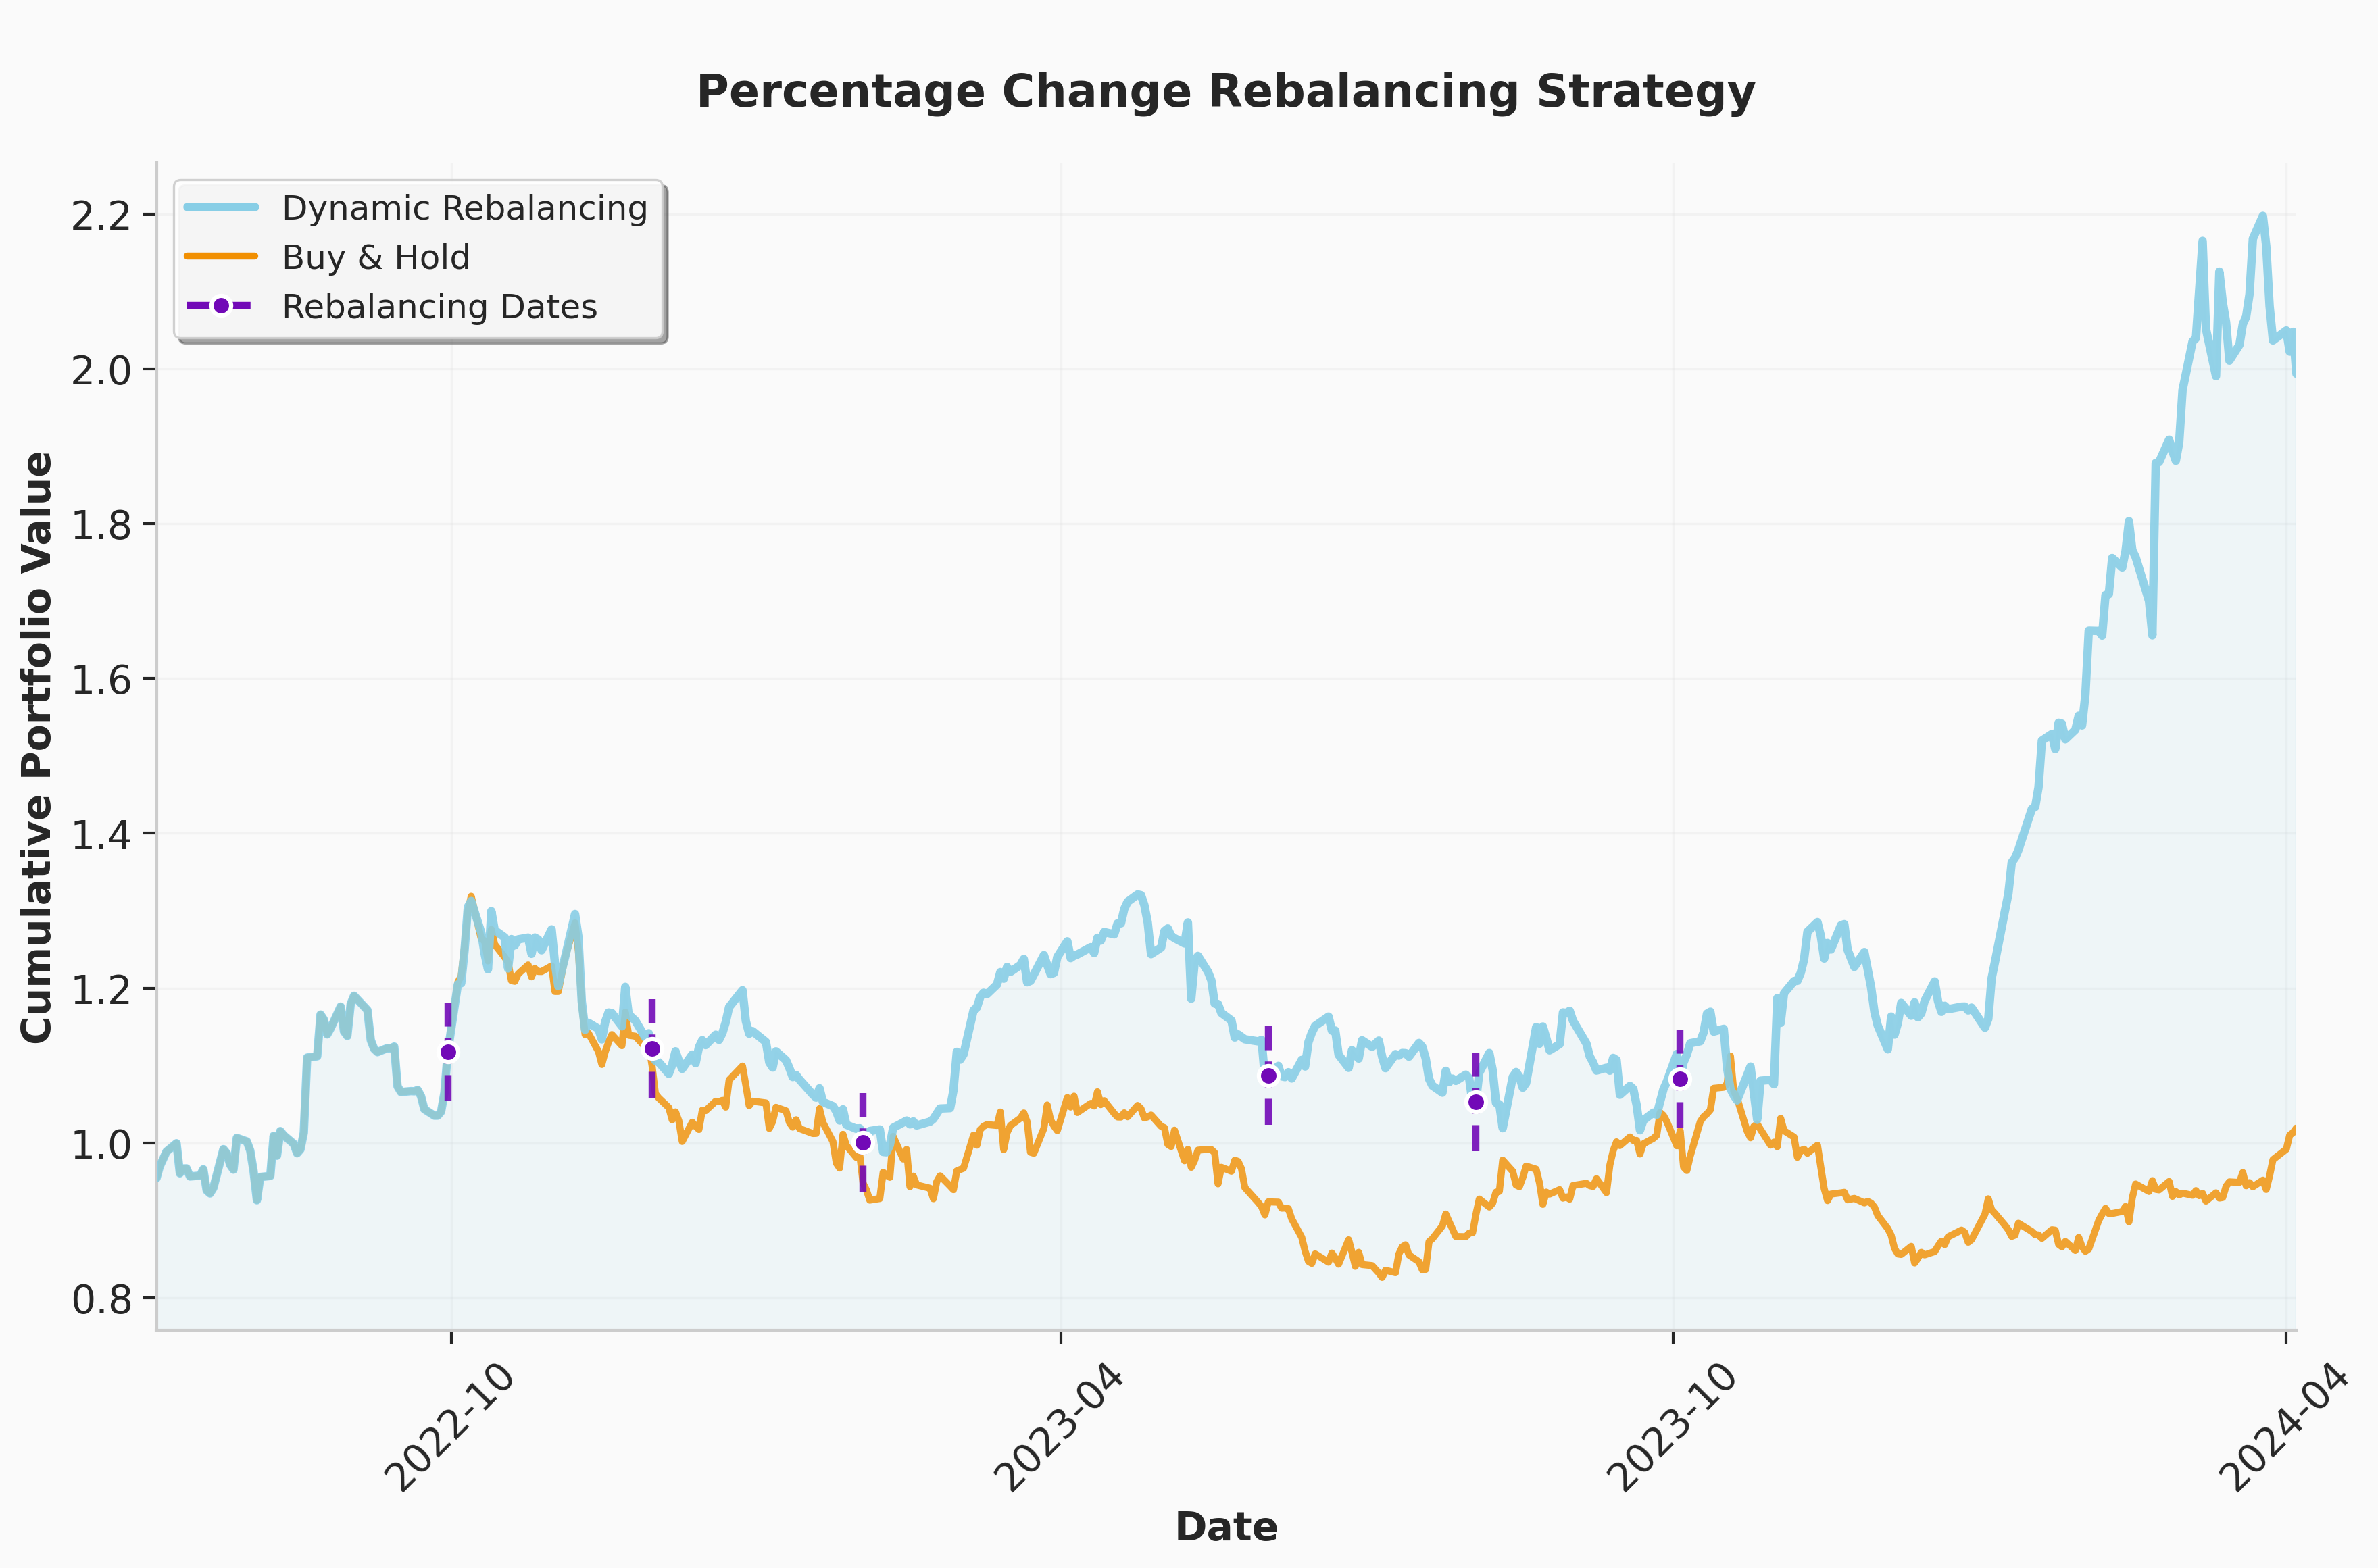

In [4]:
# --- Select Scenario for Rebalancing ---
selected_rebal_scenario_name = 'rebalancing_trading_period'
rebal_trading_start_date, rebal_trading_end_date = "2022-07-01", "2024-05-01"

# Look-back and look-forward windows for backtesting
rebal_look_back_window = 252       # Historical period used for optimization (trading days)
rebal_look_forward_window = 21     # Testing period (out-of-sample performance)

# CVaR parameters for these rebalancing strategies will use 'rebal_cvar_params'
# GPU solver configurations are already globally defined in 'gpu_solver_settings'
#Define re-optimization tolerance threshold for percent change
percent_change_tolerance = -0.005   # trigger threshold

# Set re-optimization criteria
pct_change_re_optimize_criteria = {"type": "pct_change", "threshold": percent_change_tolerance}

#select solver
solver_settings = {'solver':cp.CUOPT, 'verbose': False}

# Execute portfolio rebalancing
pct_change_rebalancing_obj = rebalance.rebalance_portfolio(
    dataset_directory=sp500_dataset_directory,
    trading_start=rebal_trading_start_date,
    trading_end=rebal_trading_end_date,
    look_forward_window=rebal_look_forward_window,
    look_back_window=rebal_look_back_window,
    cvar_params=rebal_cvar_params,          # Using general rebalancing CVaR params
    solver_settings = solver_settings,         # Using global GPU configs
    re_optimize_criteria=pct_change_re_optimize_criteria,
    return_type=log_return_type,
    print_opt_result = False
)

# Retrieve and plot optimization results
pct_change_results_df, pct_change_re_optimize_dates, cumulative_portfolio_value_array = pct_change_rebalancing_obj.re_optimize(plot_results=True, save_plot = True, results_dir = "result/rebalancing_strategies")

In [5]:
pct_change_results_df.to_csv(f"./result/rebalancing_strategies/results_df_gif/gpu_percent_change_num-scen{rebal_cvar_params.num_scen}.csv")
cumulative_portfolio_value_array.to_csv(f"./result/rebalancing_strategies/cum_val/gpu_percent_change_num-scen{rebal_cvar_params.num_scen}.csv")
pct_change_rebalancing_obj.buy_and_hold_cumulative_portfolio_value.to_csv(f"./result/rebalancing_strategies/buy_and_hold/gpu_percent_change_buy_and_hold_num-scen{rebal_cvar_params.num_scen}.csv")

BASELINE (BUY & HOLD) ANALYSIS
Period: 2022-07-01 to 2024-05-01
Strategy: Single optimization at start

BASELINE COMPLETE
Final portfolio value: $1.03
Total return: +7.42%
Data points collected: 441

DYNAMIC REBALANCING ANALYSIS
Period: 2022-07-01 to 2024-05-01
Strategy: Percentage Change
Threshold: -0.005
Look-forward window: 21 days
Look-back window: 252 days
Rebalancing triggered on 2022-09-30 | Event #1 | Portfolio value: $1.16
Rebalancing triggered on 2022-11-30 | Event #2 | Portfolio value: $1.12
Rebalancing triggered on 2023-02-01 | Event #3 | Portfolio value: $1.03
Rebalancing triggered on 2023-06-02 | Event #4 | Portfolio value: $1.10
Rebalancing triggered on 2023-08-03 | Event #5 | Portfolio value: $1.08
Rebalancing triggered on 2023-10-03 | Event #6 | Portfolio value: $1.10

ANALYSIS COMPLETE
Total rebalancing events: 6
Final portfolio value: $2.04
Total return: +113.51%
Data points collected: 441

Plot saved: result/rebalancing_strategies/rebalancing_pct-change_with_thresho

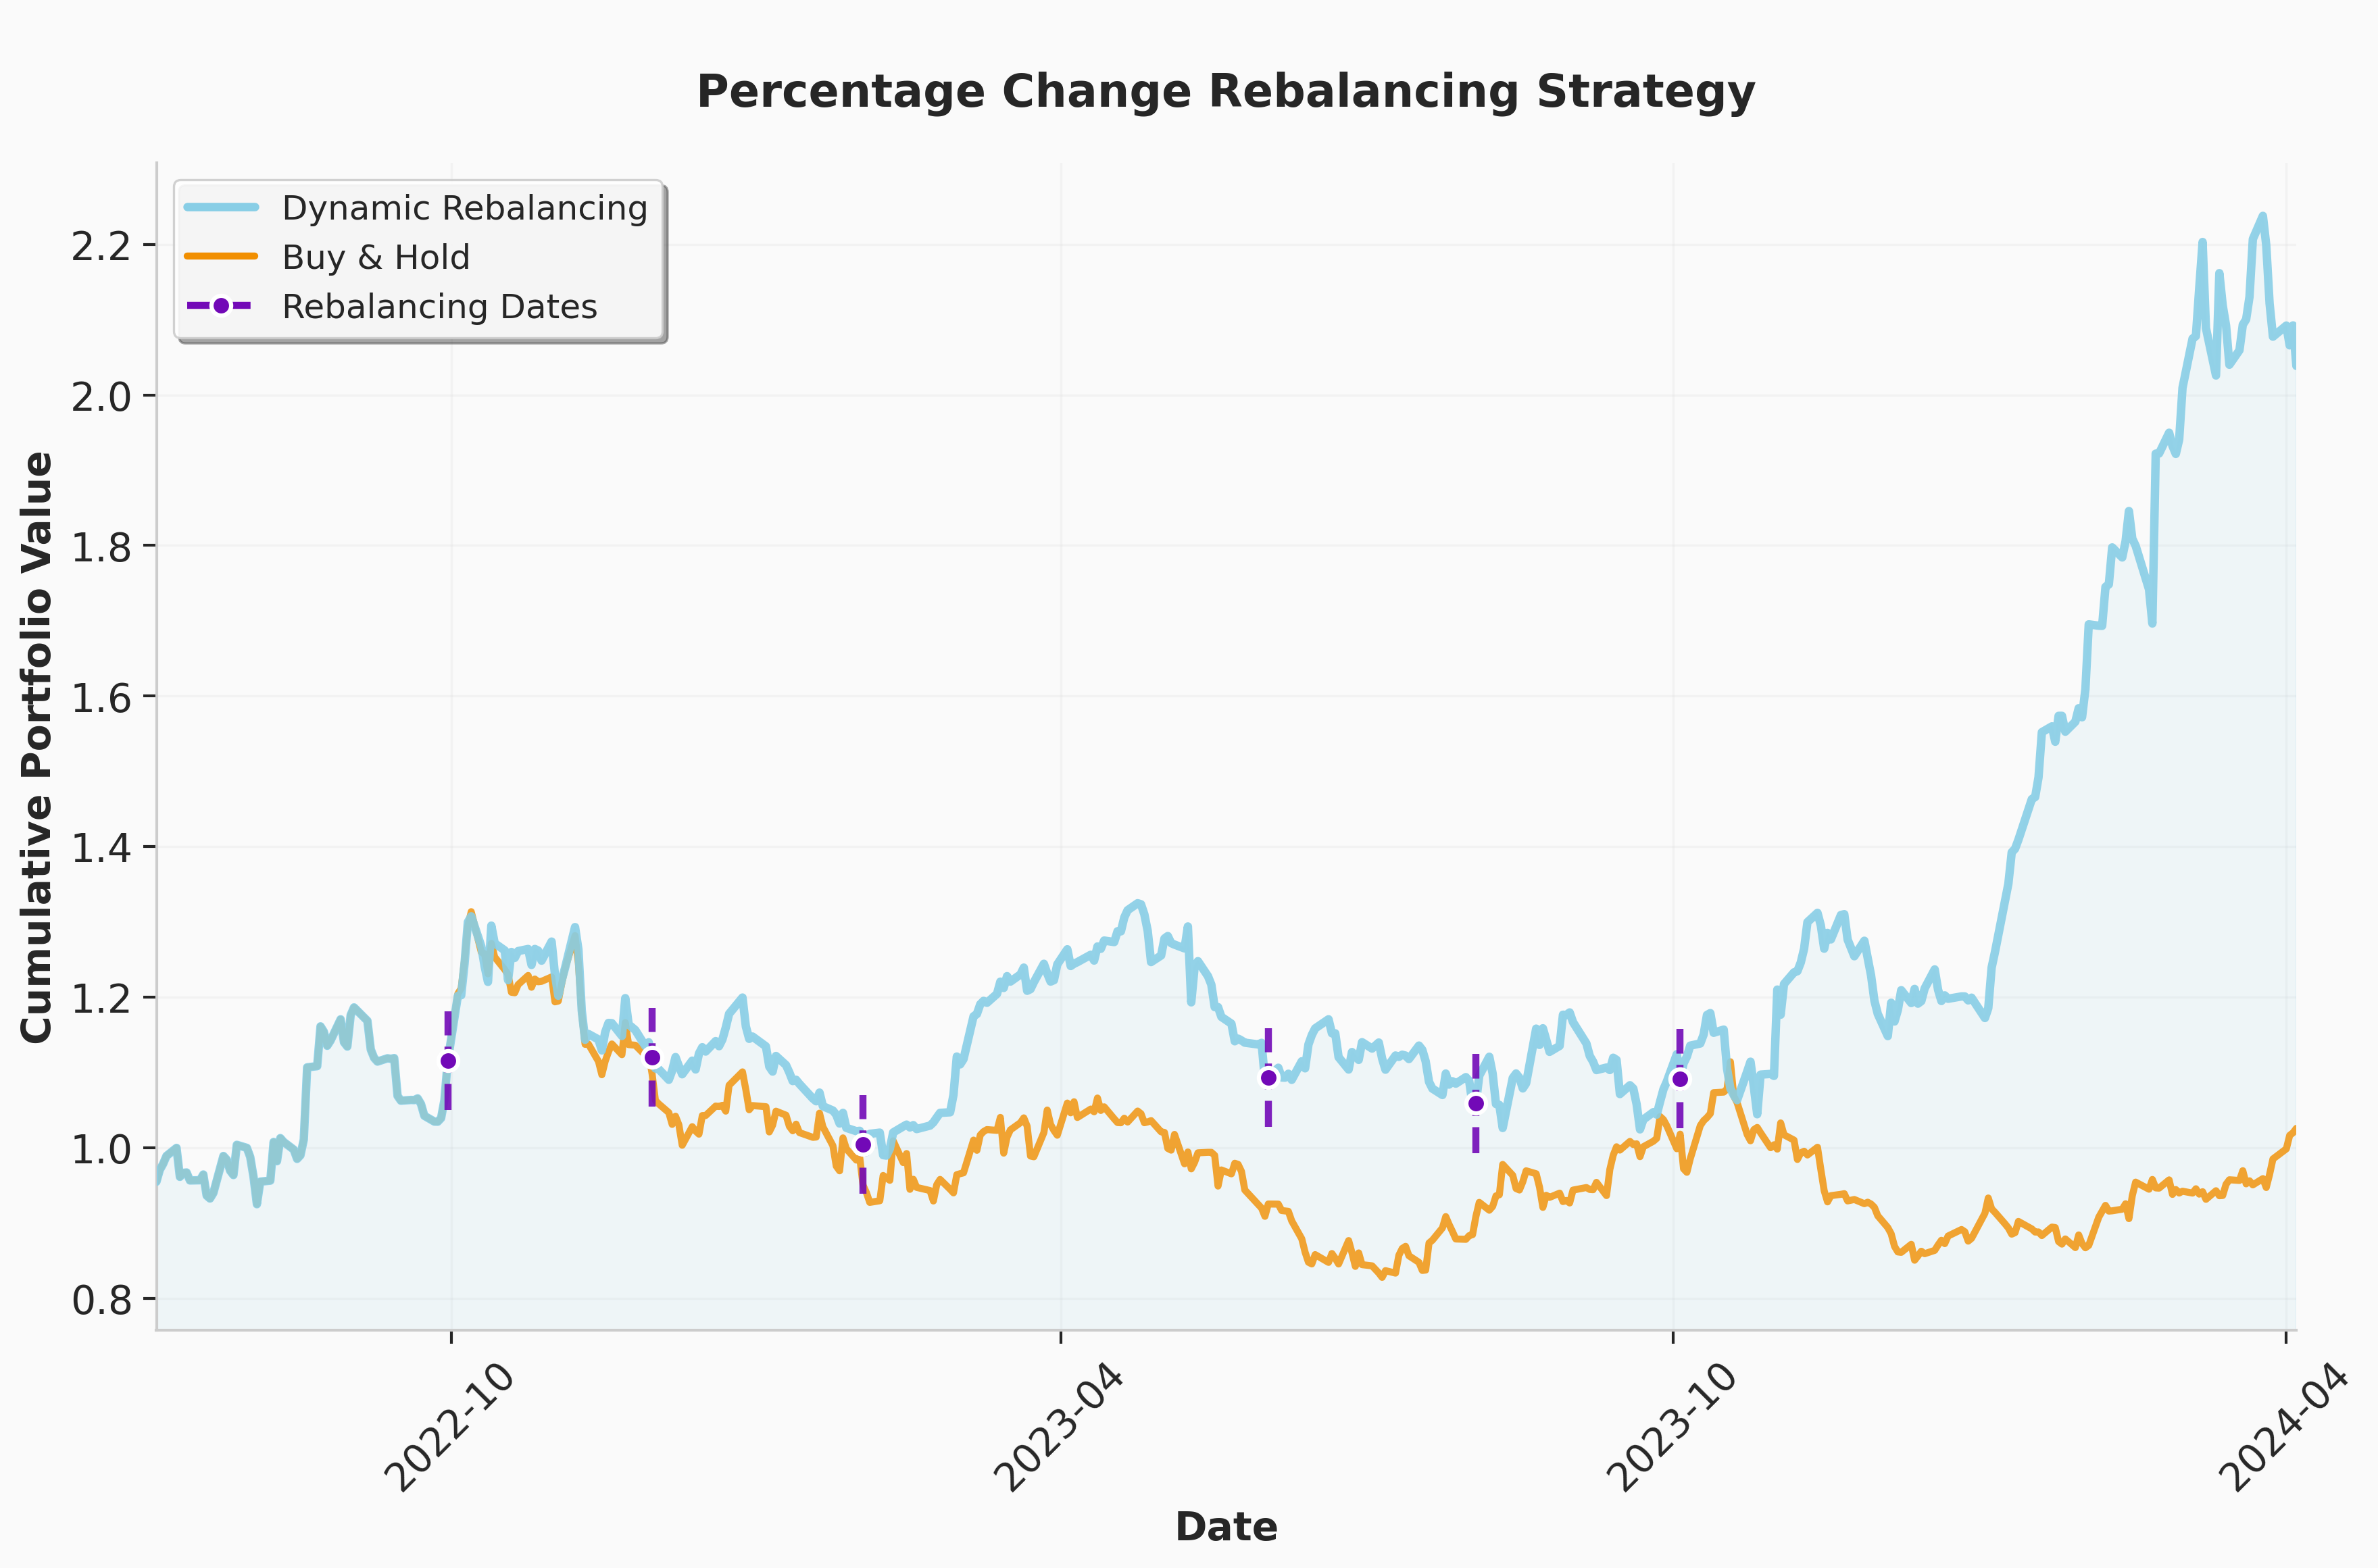

In [6]:
# --- Select Scenario for Rebalancing ---


# Set re-optimization criteria
pct_change_re_optimize_criteria = {"type": "pct_change", "threshold": percent_change_tolerance}

#CPU solver
solver_settings = {"solver": cp.HIGHS, "verbose": False, 'highs_options':{'optimality_tolerance':1e-4}}

# Execute portfolio rebalancing
pct_change_rebalancing_obj = rebalance.rebalance_portfolio(
    dataset_directory=sp500_dataset_directory,
    trading_start=rebal_trading_start_date,
    trading_end=rebal_trading_end_date,
    look_forward_window=rebal_look_forward_window,
    look_back_window=rebal_look_back_window,
    cvar_params=rebal_cvar_params,          # Using general rebalancing CVaR params
    solver_settings = solver_settings,         # Using global GPU configs
    re_optimize_criteria=pct_change_re_optimize_criteria,
    return_type=log_return_type,
    print_opt_result = False
)

# Retrieve and plot optimization results
pct_change_results_df, pct_change_re_optimize_dates, cumulative_portfolio_value_array = pct_change_rebalancing_obj.re_optimize(plot_results=True, save_plot = True, results_dir = "result/rebalancing_strategies")

In [7]:
pct_change_results_df.to_csv(f"./result/rebalancing_strategies/results_df_gif/cpu_percent_change_num-scen{rebal_cvar_params.num_scen}.csv")
cumulative_portfolio_value_array.to_csv(f"./result/rebalancing_strategies/cum_val/cpu_percent_change_num-scen{rebal_cvar_params.num_scen}.csv")

In [8]:
pct_change_rebalancing_obj.buy_and_hold_cumulative_portfolio_value.to_csv(f"./result/rebalancing_strategies/buy_and_hold/cpu_percent_change_buy_and_hold_num-scen{rebal_cvar_params.num_scen}.csv")

BASELINE (BUY & HOLD) ANALYSIS
Period: 2022-07-01 to 2024-05-01
Strategy: Single optimization at start
Setting parameter log_to_console to false

BASELINE COMPLETE
Final portfolio value: $0.80
Total return: -16.55%
Data points collected: 420

DYNAMIC REBALANCING ANALYSIS
Period: 2022-07-01 to 2024-05-01
Strategy: Drift From Optimal
Threshold: 0.05
Look-forward window: 42 days
Look-back window: 252 days
Setting parameter log_to_console to false
Rebalancing triggered on 2022-08-31 | Event #1 | Portfolio value: $1.14
Setting parameter log_to_console to false
Rebalancing triggered on 2022-10-31 | Event #2 | Portfolio value: $1.13
Setting parameter log_to_console to false
Rebalancing triggered on 2022-12-30 | Event #3 | Portfolio value: $0.94
Setting parameter log_to_console to false
Rebalancing triggered on 2023-03-03 | Event #4 | Portfolio value: $0.90
Setting parameter log_to_console to false
Rebalancing triggered on 2023-05-03 | Event #5 | Portfolio value: $0.97
Setting parameter log_to

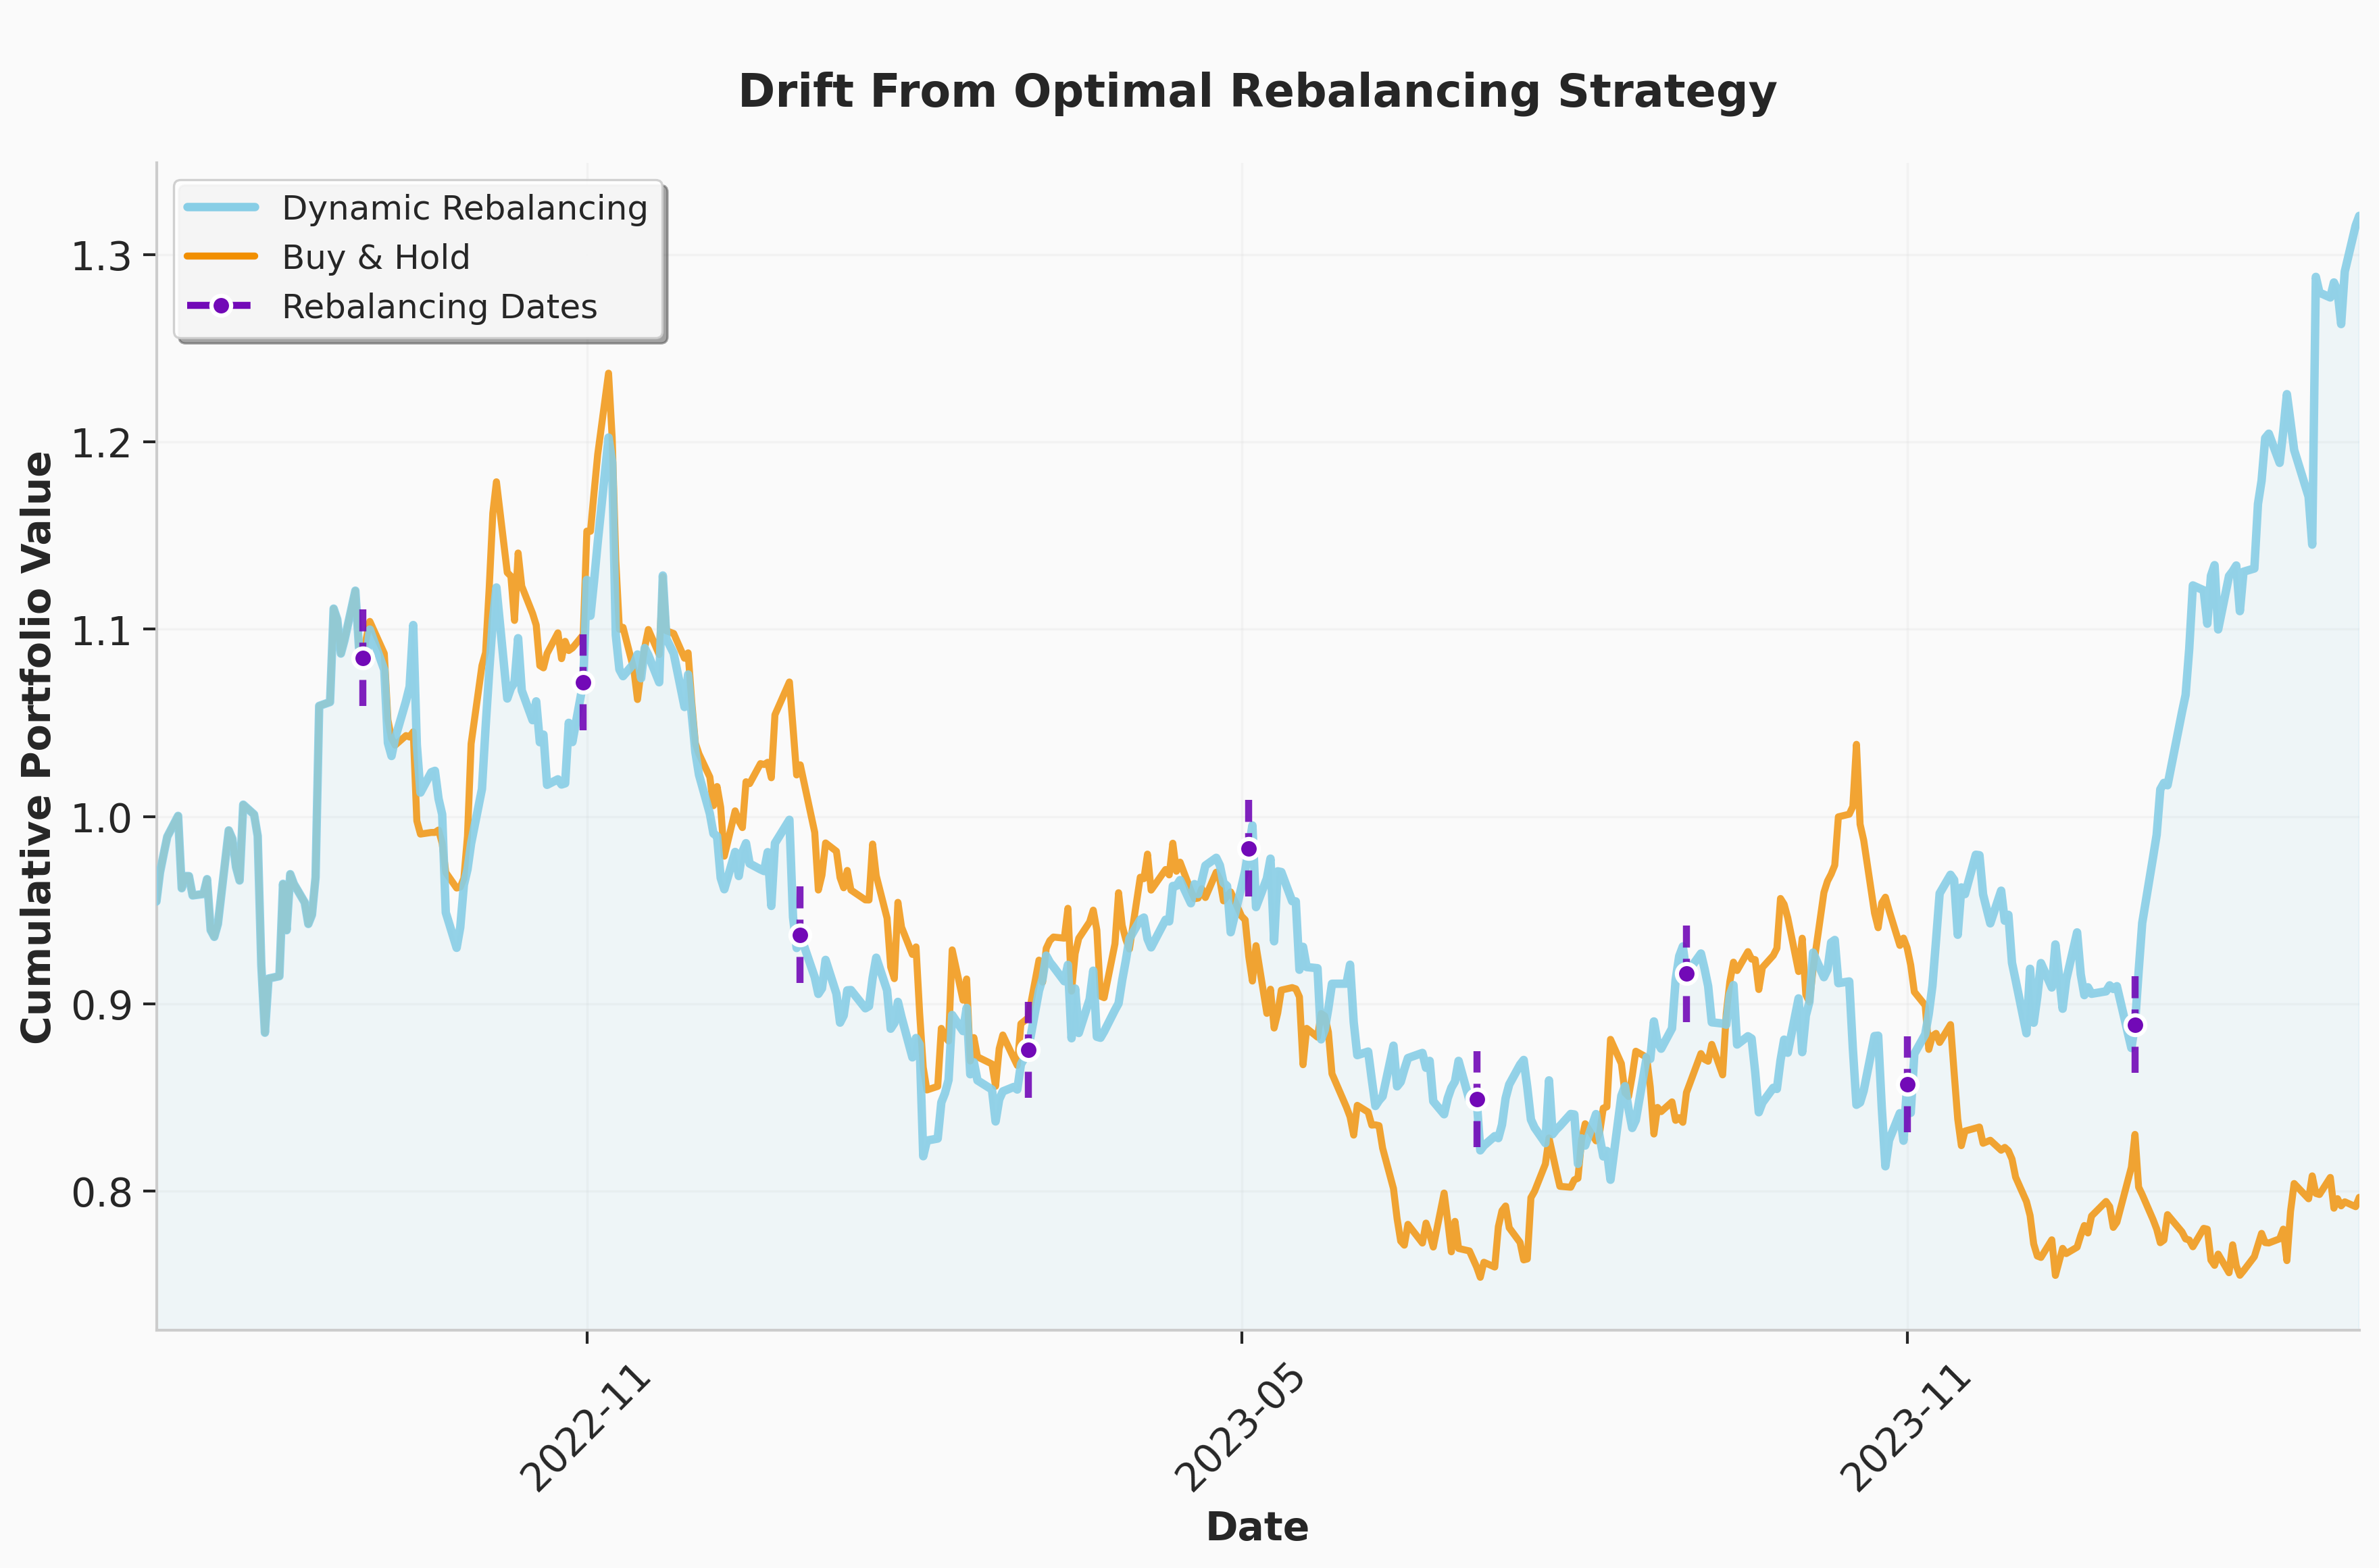

In [6]:
# --- Select Scenario for Rebalancing ---
selected_rebal_scenario_name = 'rebalancing_trading_period'
rebal_trading_start_date, rebal_trading_end_date = "2022-07-01", "2024-05-01"

# Look-back and look-forward windows for backtesting
rebal_look_back_window = 252       # Historical period used for optimization (trading days)
rebal_look_forward_window = 42     # Testing period (out-of-sample performance)

# Define drift tolerance threshold
drift_rebal_tolerance = 0.05        # Rebalance if weight deviation (L2 norm) exceeds tolerance

# Set re-optimization criteria for drift
drift_re_optimize_criteria = {
    "type": "drift_from_optimal",
    "threshold": drift_rebal_tolerance,
    "norm": 1,                # Using L2 norm
}

#GPU solver
solver_settings = {"solver": cp.CUOPT, "verbose": False, 'highs_options':{'optimality_tolerance':1e-4}}

# Execute portfolio rebalancing
drift_rebalancing_obj = rebalance.rebalance_portfolio(
    dataset_directory=sp500_dataset_directory,
    trading_start=rebal_trading_start_date,
    trading_end=rebal_trading_end_date,
    look_forward_window=rebal_look_forward_window,
    look_back_window=rebal_look_back_window,
    cvar_params=rebal_cvar_params,
    solver_settings = solver_settings,
    re_optimize_criteria=drift_re_optimize_criteria,
    return_type=log_return_type,
    print_opt_result=False
)

# Retrieve and plot results
drift_results_df, drift_re_optimize_dates, cumulative_portfolio_value_array = drift_rebalancing_obj.re_optimize(plot_results=True, save_plot = True, results_dir = "result/rebalancing_strategies")

In [7]:
device = 'gpu'
drift_results_df.to_csv(f"./result/rebalancing_strategies/results_df_gif/{device}_drift_from_optimal_num-scen{rebal_cvar_params.num_scen}.csv")
cumulative_portfolio_value_array.to_csv(f"./result/rebalancing_strategies/cum_val/{device}_drift_from_optimal_num-scen{rebal_cvar_params.num_scen}.csv")
drift_rebalancing_obj.buy_and_hold_cumulative_portfolio_value.to_csv(f"./result/rebalancing_strategies/buy_and_hold/{device}_drift_from_optimal_buy_and_hold_num-scen{rebal_cvar_params.num_scen}.csv")

BASELINE (BUY & HOLD) ANALYSIS
Period: 2022-07-01 to 2024-05-01
Strategy: Single optimization at start

BASELINE COMPLETE
Final portfolio value: $0.80
Total return: -16.46%
Data points collected: 420

DYNAMIC REBALANCING ANALYSIS
Period: 2022-07-01 to 2024-05-01
Strategy: Drift From Optimal
Threshold: 0.05
Look-forward window: 42 days
Look-back window: 252 days
Rebalancing triggered on 2022-08-31 | Event #1 | Portfolio value: $1.14
Rebalancing triggered on 2022-10-31 | Event #2 | Portfolio value: $1.13
Rebalancing triggered on 2022-12-30 | Event #3 | Portfolio value: $0.94
Rebalancing triggered on 2023-03-03 | Event #4 | Portfolio value: $0.92
Rebalancing triggered on 2023-05-03 | Event #5 | Portfolio value: $1.00
Rebalancing triggered on 2023-07-05 | Event #6 | Portfolio value: $0.84
Rebalancing triggered on 2023-09-01 | Event #7 | Portfolio value: $0.94
Rebalancing triggered on 2023-11-01 | Event #8 | Portfolio value: $0.87
Rebalancing triggered on 2024-01-03 | Event #9 | Portfolio v

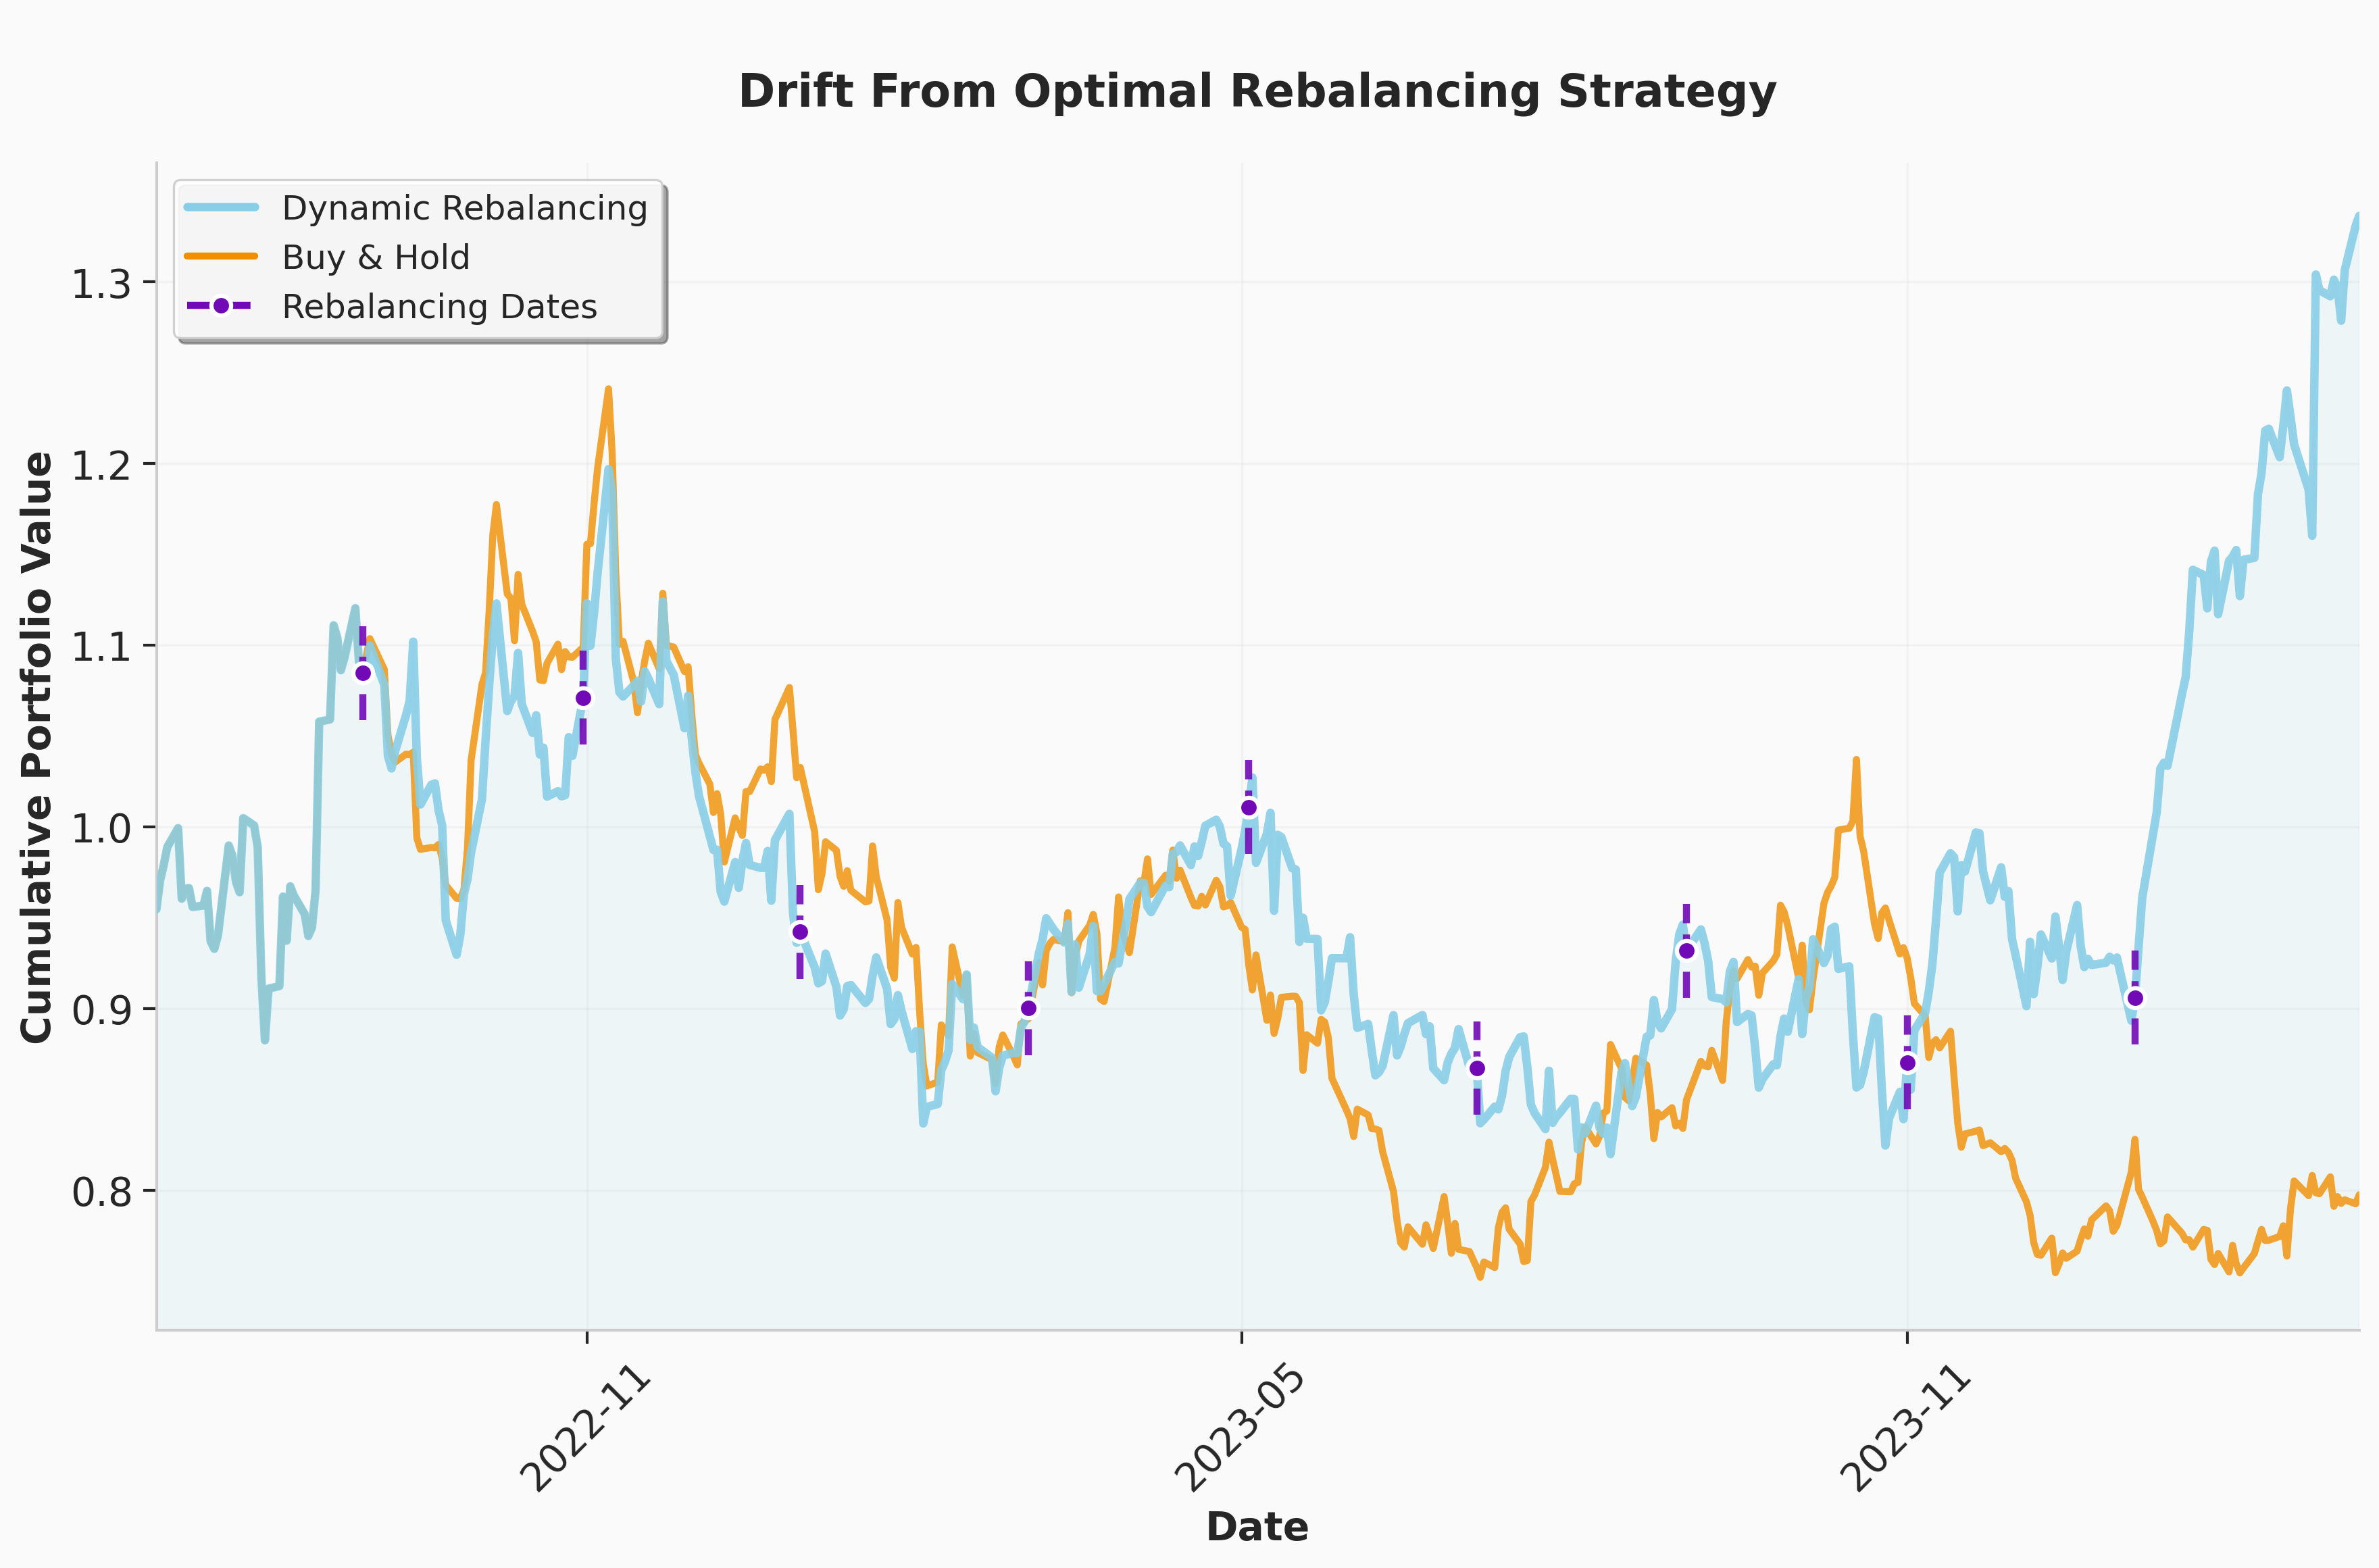

In [8]:
#CPU solver
solver_settings = {"solver": cp.HIGHS, "verbose": False, 'highs_options':{'optimality_tolerance':1e-4}}

# Execute portfolio rebalancing
drift_rebalancing_obj = rebalance.rebalance_portfolio(
    dataset_directory=sp500_dataset_directory,
    trading_start=rebal_trading_start_date,
    trading_end=rebal_trading_end_date,
    look_forward_window=rebal_look_forward_window,
    look_back_window=rebal_look_back_window,
    cvar_params=rebal_cvar_params,
    solver_settings = solver_settings,
    re_optimize_criteria=drift_re_optimize_criteria,
    return_type=log_return_type,
    print_opt_result=False
)

# Retrieve and plot results
drift_results_df, drift_re_optimize_dates, drift_cumulative_portfolio_value = drift_rebalancing_obj.re_optimize(plot_results=True, save_plot = True, results_dir = "result/rebalancing_strategies")

In [9]:
device = 'cpu'
drift_results_df.to_csv(f"./result/rebalancing_strategies/results_df_gif/{device}_drift_from_optimal_num-scen{rebal_cvar_params.num_scen}.csv")
cumulative_portfolio_value_array.to_csv(f"./result/rebalancing_strategies/cum_val/{device}_drift_from_optimal_num-scen{rebal_cvar_params.num_scen}.csv")
drift_rebalancing_obj.buy_and_hold_cumulative_portfolio_value.to_csv(f"./result/rebalancing_strategies/buy_and_hold/{device}_drift_from_optimal_buy_and_hold_num-scen{rebal_cvar_params.num_scen}.csv")

In [11]:
drift_rebalancing_obj.buy_and_hold_results

,drift_from_optimal,re_optimized,portfolio_value,solver_time,optimal_portfolio
2022-07-01,0.0,False,1.0,46.029053,None
2022-08-31,0.0,False,1.136299,None,<src.portfolio.Portfolio object at 0x7fb0c50cb...
2022-10-31,0.0,False,1.141589,None,<src.portfolio.Portfolio object at 0x7fb0c50cb...
2022-12-30,0.0,False,1.020243,None,<src.portfolio.Portfolio object at 0x7fb0c50cb...
2023-03-03,0.0,False,0.914985,None,<src.portfolio.Portfolio object at 0x7fb0c50cb...
2023-05-03,0.0,False,0.913525,None,<src.portfolio.Portfolio object at 0x7fb0c50cb...
2023-07-05,0.0,False,0.760301,None,<src.portfolio.Portfolio object at 0x7fb0c50cb...
2023-09-01,0.0,False,0.859042,None,<src.portfolio.Portfolio object at 0x7fb0c50cb...
2023-11-01,0.0,False,0.915267,None,<src.portfolio.Portfolio object at 0x7fb0c50cb...
2024-01-03,0.0,False,0.826557,None,<src.portfolio.Portfolio object at 0x7fb0c50cb...


In [13]:
drift_results_df['optimal_portfolio'].iloc[0].print_clean()

({'CCL': np.float64(-0.20000000000000007),
  'MCK': np.float64(0.32127963747383015),
  'NFLX': np.float64(-0.3),
  'OXY': np.float64(0.7787203625261699)},
 0.4)

In [ ]:
cumulative_portfolio_value_array[(cumulative_portfolio_value_array.index > "2021-06-25") & (cumulative_portfolio_value_array.index < "2021-08-01")]